In [2]:
from pyrms import rms
from diffeqpy import de
from julia import Main
import yaml
from julia import Sundials
from diffeqpy import de
import time 
import matplotlib
from copy import deepcopy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmg.model import ReactionModel
from rmgpy.species import Species
from rmgpy.kinetics import StickingCoefficientBEP, StickingCoefficient, SurfaceArrheniusBEP, SurfaceArrhenius
from rmgpy.data.kinetics.database import KineticsDatabase
import os
import copy
%matplotlib inline

In [3]:

if os.path.exists("/work"):
    prefix = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/"
else: 
    prefix = "/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/meOH_repos/uncertainty_analysis/"
file_dir = os.path.join(prefix,"rmg_gua", "baseline", "rms", "chem32.rms")
phase_dict = rms.readinput(file_dir)

In [4]:
base_path = "/".join(file_dir.split("/")[:-2])
base_path = os.path.join(base_path, "chemkin")
cmkn_path = os.path.join(base_path, "chem_annotated-gas.inp")
cmkn_surf_path = os.path.join(base_path, "chem_annotated-surface.inp")
cmkn_dict_path = os.path.join(base_path, "species_dictionary.txt")
# file_dir.replace(file_dir.split("/")[-1], "/chemkin")

In [5]:
expt_condts = os.path.join(prefix,"rmg_gua","gua_cantera","all_experiments_reorg_sbr.yaml")

with open(expt_condts, 'r') as file:
    data = yaml.safe_load(file)

# pick just one experiment for example 
conditions = data[2]

# convert volume flow to molar flow
conditions["volume_flowrate"]

FC_temp = 293.15
conditions["molar_flow"] = conditions["volume_flowrate"] * 1.01325e5 / (8.3145 * FC_temp) 

In [6]:
intfc_key = list(phase_dict.keys())[0]

# mechanism dictionaries index:  phase_dict[phasename]["Species" or "Reactions"]
gasspcs = phase_dict["gas"]["Species"]
gasrxns = phase_dict["gas"]["Reactions"]
surfacespcs = phase_dict["surface"]["Species"]
surfacerxns = phase_dict["surface"]["Reactions"]
interfacerxns = phase_dict[intfc_key]["Reactions"]

In [7]:
#Define the phase (how species thermodynamic and kinetic properties calculated)
ig = rms.IdealGas(gasspcs,gasrxns,name="gas") 
cat = rms.IdealSurface(surfacespcs, surfacerxns, 2.943e-5, name="surface")

In [8]:
# Set simulation gas Initial Temp and Pressure
initialcondsgas = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
} 
# Define the domain (encodes how system thermodynamic properties calculated)
domaingas,y0gas,pgas = rms.ConstantTPDomain(phase=ig,initialconds=initialcondsgas,sensitivity=True)

In [9]:
# Set simulation surf Initial Temp and Pressure
V = conditions["volume"]
A = conditions["catalyst_area"]
initialconds = {
        "T":conditions["temperature"],
        "A":conditions["catalyst_area"],
        "X":cat.sitedensity*A
} 
# Define the domain (encodes how system thermodynamic properties calculated)
domaincat,y0cat,pcat = rms.ConstantTAPhiDomain(phase=cat,initialconds=initialconds,sensitivity=True);

## make reactor, inlet and outlet
- makes an anonymous function x->42, is that velocity in? need to check if it is velocity or volume flowrate
- also, I think the ```phi``` refers to chemical potential, but I should check, I think constantTPhi is just const T for our case. 

In [10]:
initialcondsinlet = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
    }

# construct reactor
inter,pinter = rms.ReactiveInternalInterfaceConstantTPhi(domaingas,domaincat,interfacerxns,initialcondsinlet["T"],A);

# make inlet and outlet
inletgas = rms.Inlet(domaingas,initialcondsinlet,Main.eval("x->"+str(conditions["molar_flow"])))
outletgas = rms.Outlet(domaingas,Main.eval("x->"+str(conditions["molar_flow"])))

In [11]:
# Define domains and interfaces
domains = (domaingas,domaincat)
interfaces = [inter,inletgas,outletgas]

# create a reactor for the system
react,y0,p = rms.Reactor(domains,(y0gas,y0cat),(0.0,100),interfaces,(pgas,pcat,pinter)) # Create the reactor object

In [12]:
# run the simulation
t1 = time.time()
sol = de.solve(react.ode,de.CVODE_BDF(),abstol=1e-20,reltol=1e-8)
t2 = time.time()
print("elapsed time for sim: ", t2-t1)

elapsed time for sim:  35.474173069000244


In [13]:
ssys = rms.SystemSimulation(sol,domains,interfaces,p)

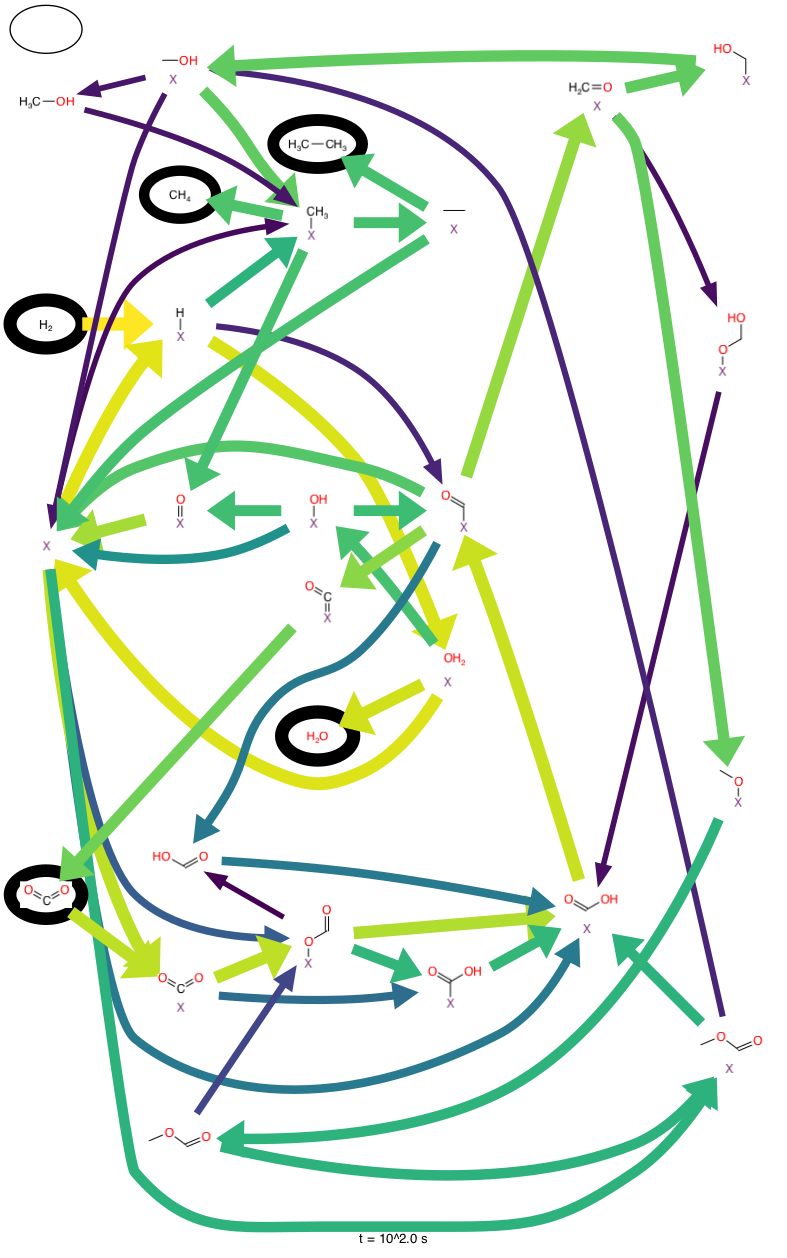

In [14]:
rms.getfluxdiagram(ssys,100)

In [15]:
# now, run it with the the peuquse parameters
import pickle

peuq_pickle = os.path.join(
    prefix, "rmg_gua", "gua_peuqse", "02_do_optimizelogp", 
    "pickles", "multistart_MAP_logP_and_parameters_values.pkl"
)

# load pickle 
with open(peuq_pickle, "rb") as f:
    peuq_results = pickle.load(f)
# sort the results array by the first value (logP)
peuq_results = peuq_results[peuq_results[:,0].argsort()]

os.path.join(
    prefix, "rmg_gua", "gua_peuqse", "ct_initial_small.yaml"
)

A = peuq_results[-1][1]
Ea = peuq_results[-1][2]

In [19]:
A,Ea

(14.738186060646191, 30000000.105992153)

In [21]:
import collections
import cantera as ct
# load translate yaml
with open("../rmg_2_ck_dict.yaml", "r") as f:
    rmg_2_ck_dict = yaml.load(f, Loader=yaml.FullLoader)


ct_file = os.path.join(
    prefix, "rmg_gua", "baseline", "cantera", "chem_annotated.cti"
)
gas = ct.Solution(ct_file, "gas")
surf = ct.Interface(ct_file, "surface1", [gas])
surf_rxn = surf.reaction(149)

ct_reac = collections.Counter(surf_rxn.reactants.keys())
ct_prod = collections.Counter(surf_rxn.products.keys())
# iterate through 
rms_dir = os.path.join(prefix,"rmg_gua", "baseline", "rms", "chem32.rms")
new_rms_dir = os.path.join(prefix,"rmg_gua", "baseline", "rms", "chem32_new.rms")

with open(rms_dir, "r") as f:
    rms_mech = yaml.load(f, Loader=yaml.FullLoader)



# iterate through the reactions
for rxn in rms_mech["Reactions"]:
    reac = copy.deepcopy(rxn["reactants"])
    for spec in reac:
        if spec in rmg_2_ck_dict:
            reac[reac.index(spec)] = rmg_2_ck_dict[spec]
    prod = copy.deepcopy(rxn["products"])
    for spec in prod:
        if spec in rmg_2_ck_dict:
            prod[prod.index(spec)] = rmg_2_ck_dict[spec]

    reactants = collections.Counter(reac)
    products = collections.Counter(prod)
    fwd = reactants == ct_reac and products == ct_prod
    rev = reactants == ct_prod and products == ct_reac
    # print(reactants, ct_reac)
    if rev or fwd:
        print(rxn)
        # rxn.reactants
        rxn["kinetics"]["A"] = float(A/1e3) 
        rxn["kinetics"]["Ea"] = float(Ea/1e3) #j/kmol to j/mol

with open(new_rms_dir, "w") as f:
    yaml.dump(rms_mech, f)



{'kinetics': {'A': 10000000000000.0, 'Ea': 0.0, 'n': 0.0, 'type': 'Arrhenius'}, 'products': ['H2O*', 'CH3X'], 'radicalchange': 0, 'reactants': ['H*', 'CH3OH*'], 'type': 'ElementaryReaction'}


In [22]:
phase_dict = rms.readinput(new_rms_dir)

In [23]:
expt_condts = os.path.join(prefix,"rmg_gua","gua_cantera","all_experiments_reorg_sbr.yaml")

with open(expt_condts, 'r') as file:
    data = yaml.safe_load(file)

# pick just one experiment for example 
conditions = data[2]

# convert volume flow to molar flow
conditions["volume_flowrate"]

FC_temp = 293.15
conditions["molar_flow"] = conditions["volume_flowrate"] * 1.01325e5 / (8.3145 * FC_temp) 

In [24]:
intfc_key = list(phase_dict.keys())[0]

# mechanism dictionaries index:  phase_dict[phasename]["Species" or "Reactions"]
gasspcs = phase_dict["gas"]["Species"]
gasrxns = phase_dict["gas"]["Reactions"]
surfacespcs = phase_dict["surface"]["Species"]
surfacerxns = phase_dict["surface"]["Reactions"]
interfacerxns = phase_dict[intfc_key]["Reactions"]

In [25]:
#Define the phase (how species thermodynamic and kinetic properties calculated)
ig = rms.IdealGas(gasspcs,gasrxns,name="gas") 
cat = rms.IdealSurface(surfacespcs, surfacerxns, 2.943e-5, name="surface")

In [26]:
# Set simulation gas Initial Temp and Pressure
initialcondsgas = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
} 
# Define the domain (encodes how system thermodynamic properties calculated)
domaingas,y0gas,pgas = rms.ConstantTPDomain(phase=ig,initialconds=initialcondsgas,sensitivity=True)

In [27]:
# Set simulation surf Initial Temp and Pressure
V = conditions["volume"]
A = conditions["catalyst_area"]
initialconds = {
        "T":conditions["temperature"],
        "A":conditions["catalyst_area"],
        "X":cat.sitedensity*A
} 
# Define the domain (encodes how system thermodynamic properties calculated)
domaincat,y0cat,pcat = rms.ConstantTAPhiDomain(phase=cat,initialconds=initialconds,sensitivity=True);

## make reactor, inlet and outlet
- makes an anonymous function x->42, is that velocity in? need to check if it is velocity or volume flowrate
- also, I think the ```phi``` refers to chemical potential, but I should check, I think constantTPhi is just const T for our case. 

In [28]:
initialcondsinlet = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
    }

# construct reactor
inter,pinter = rms.ReactiveInternalInterfaceConstantTPhi(domaingas,domaincat,interfacerxns,initialcondsinlet["T"],A);

# make inlet and outlet
inletgas = rms.Inlet(domaingas,initialcondsinlet,Main.eval("x->"+str(conditions["molar_flow"])))
outletgas = rms.Outlet(domaingas,Main.eval("x->"+str(conditions["molar_flow"])))

In [29]:
# Define domains and interfaces
domains = (domaingas,domaincat)
interfaces = [inter,inletgas,outletgas]

# create a reactor for the system
react,y0,p = rms.Reactor(domains,(y0gas,y0cat),(0.0,100),interfaces,(pgas,pcat,pinter)) # Create the reactor object

In [30]:
# run the simulation
t1 = time.time()
sol = de.solve(react.ode,de.CVODE_BDF(),abstol=1e-20,reltol=1e-8)
t2 = time.time()
print("elapsed time for sim: ", t2-t1)

elapsed time for sim:  0.0827798843383789


In [31]:
ssys = rms.SystemSimulation(sol,domains,interfaces,p)

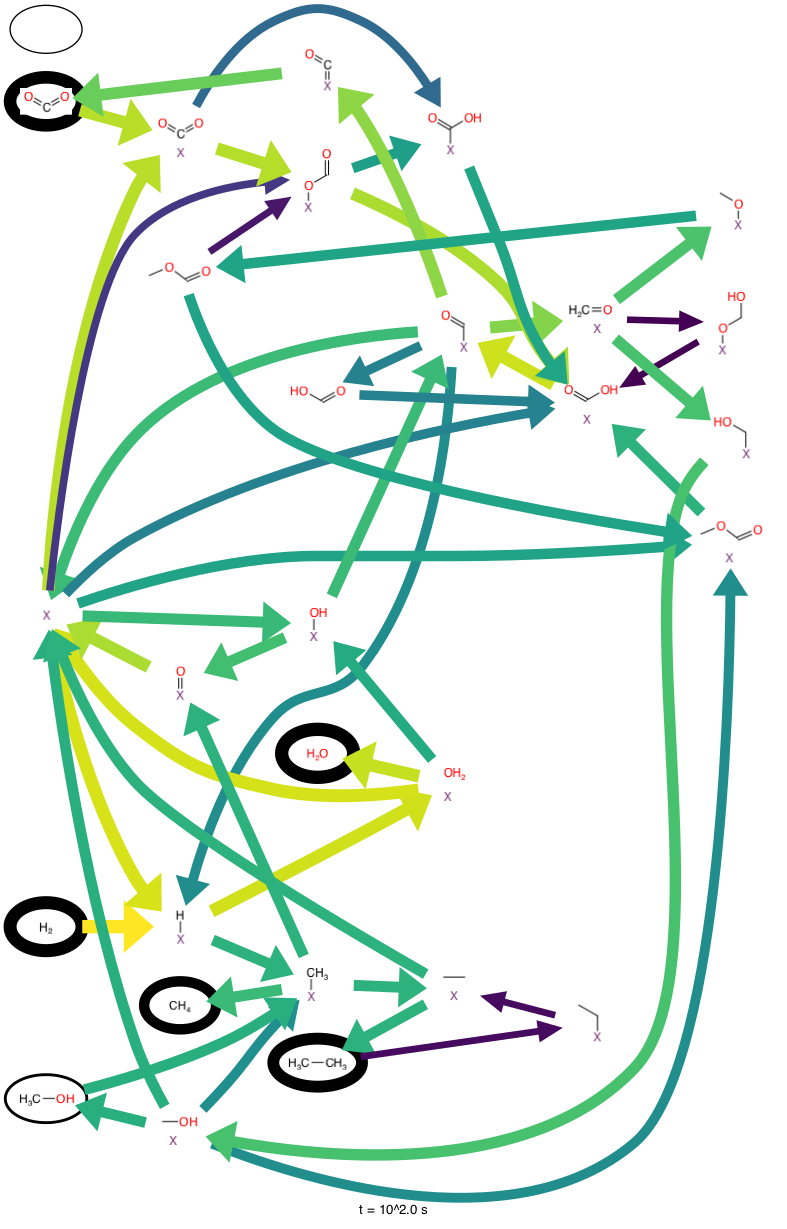

In [32]:
rms.getfluxdiagram(ssys,100)

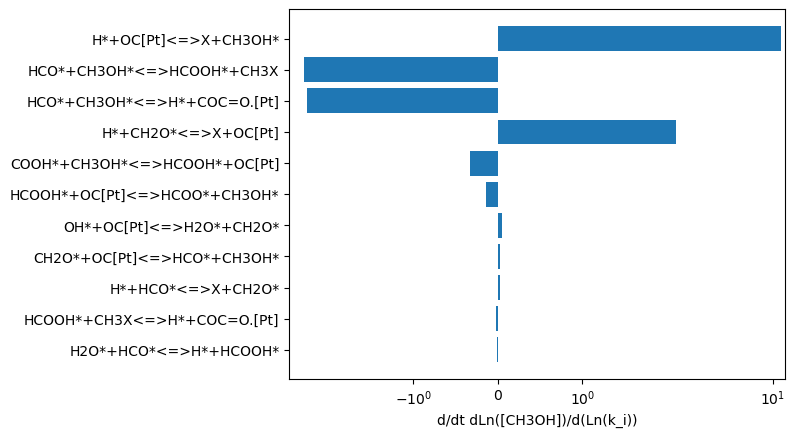

In [37]:
rms.plotrxntransitorysensitivities(ssys,"CH3OH",100)